In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import networkx as nx

from tqdm.notebook import tqdm

In [6]:
df_listings = pd.read_csv("data/raw/listings.csv")

In [7]:
cols = ['id', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'square_feet',
       'price', 'weekly_price', 'monthly_price']

df_listings[cols].sort_values("id")

,id,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,square_feet,price,weekly_price,monthly_price
3307,3353,42.355017,-71.127590,t,Apartment,Private room,1,1.0,1.0,1.0,Real Bed,NaN,$40.00,$400.00,"$1,200.00"
780,5506,42.329809,-71.095595,t,House,Private room,2,1.0,1.0,1.0,Real Bed,225.0,$145.00,$980.00,"$3,000.00"
855,6695,42.329941,-71.093505,t,Apartment,Entire home/apt,4,1.0,1.0,2.0,Real Bed,NaN,$195.00,NaN,NaN
2,6976,42.292438,-71.135765,t,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,NaN,$65.00,$395.00,"$1,350.00"
2109,8792,42.358497,-71.062011,t,Apartment,Entire home/apt,3,1.0,1.0,1.0,Real Bed,NaN,$154.00,$750.00,"$2,900.00"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1699,14924831,42.381921,-71.068837,t,House,Private room,1,1.0,1.0,1.0,Real Bed,NaN,$190.00,NaN,NaN
2789,14928000,42.300476,-71.076970,f,House,Private room,1,1.0,1.0,1.0,Real Bed,NaN,$55.00,NaN,NaN
3278,14928333,42.337349,-71.048150,f,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,NaN,$90.00,NaN,NaN
176,14933380,42.324891,-71.113440,f,Apartment,Shared room,1,1.0,1.0,1.0,Real Bed,NaN,$49.00,NaN,NaN


In [8]:
def distanceCoords(lat1, lon1, lat2, lon2):
    # Radius of the Earth in kilometers
    R = 6371.0

    # Convert latitude and longitude from degrees to radians
    lat1_rad = np.deg2rad(lat1)
    lon1_rad = np.deg2rad(lon1)
    lat2_rad = np.deg2rad(lat2)
    lon2_rad = np.deg2rad(lon2)

    # Differences in coordinates
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad    

    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    distance = R * c
    return distance

def createDistanceMatrix(df):
    rows = df.shape[0]
    all_coords = df[['latitude', 'longitude']].to_numpy()

    distance_matrix = np.zeros((rows, rows))

    for i in range(rows):
        coords = all_coords[i]
        distance = distanceCoords(coords[0], coords[1], all_coords[:, 0], all_coords[:, 1])
        distance_matrix[:, i] = distance

    return distance_matrix

def createSimilarityMatrix(distance_matrix, sim_type='inverse', **kwargs):
    if (sim_type == 'inverse'):
        #ignore the warning for divide by zero
        similarity_matrix = np.where(distance_matrix != 0, 1 / distance_matrix**2, 1000)
        similarity_matrix = np.clip(similarity_matrix, 0, 1000)
    
    elif (sim_type == 'rbf'):
        similarity_matrix = np.exp(-distance_matrix**2 / (2 * kwargs['sigma']**2))

    else:
        return

    return similarity_matrix


def calculateSparsity(matrix):
    nrEntries = matrix.shape[0]**2
    nrZeros = nrEntries - np.count_nonzero(matrix)
    return nrZeros*100 / nrEntries

In [9]:
distanceMatrix = createDistanceMatrix(df_listings)

C:\Users\erena\AppData\Local\Temp\ipykernel_45676\970546105.py:37: RuntimeWarning: divide by zero encountered in divide
  similarity_matrix = np.where(distance_matrix != 0, 1 / distance_matrix**2, 1000)


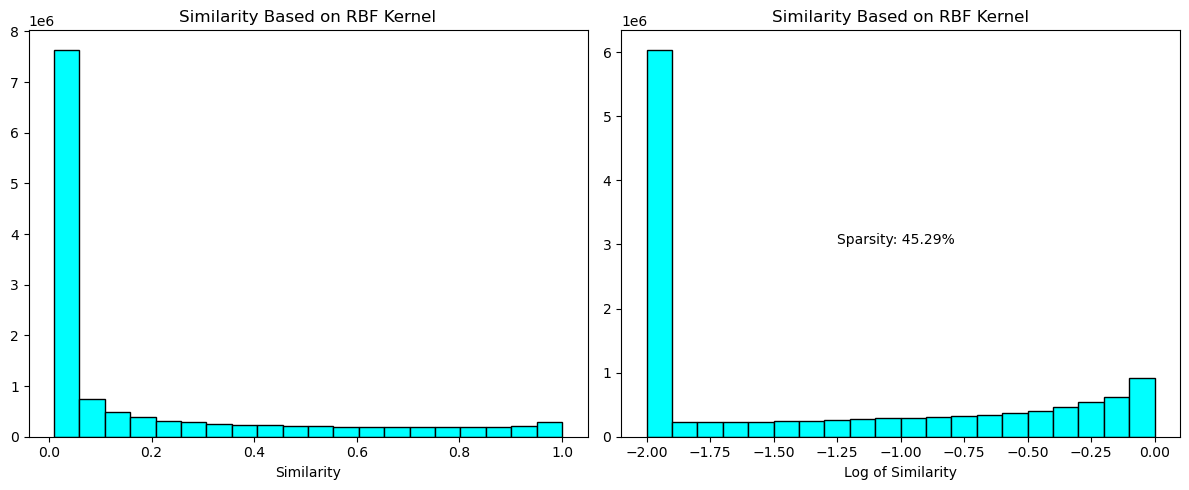

In [10]:
sim_distance = createSimilarityMatrix(distanceMatrix)
sim_rbf = createSimilarityMatrix(distanceMatrix, sim_type='rbf', sigma=1.5)

sim_rbf_sparse = np.where(sim_rbf < 0.01, 0, sim_rbf)
sparsity = calculateSparsity(sim_rbf_sparse)

sim_rbf = np.clip(sim_rbf, 1e-2, 1e2)

fig, ax = plt.subplots(ncols=2, figsize=(12, 5))

ax[0].hist(sim_rbf.flatten(), bins=20, edgecolor='black', color='cyan')
ax[0].set_xlabel("Similarity")
ax[0].set_title("Similarity Based on RBF Kernel")

ax[1].hist(np.log10(sim_rbf.flatten()), bins=20, edgecolor='black', color='cyan')
ax[1].set_xlabel("Log of Similarity")
ax[1].set_title("Similarity Based on RBF Kernel")

ax[1].text(-1.25, 3e6, f"Sparsity: {sparsity:.2f}%")

fig.tight_layout()

# fig.savefig("figures/similarity_histogram.pdf")

In [11]:
sim_rbf_sparse.shape

(3585, 3585)

In [208]:
graph = nx.Graph(sim_rbf_sparse)

nx.is_connected(graph)

True

In [13]:
df_calendar = pd.read_csv("data/raw/calendar.csv")

df_calendar = df_calendar.groupby("listing_id").filter(lambda x: not x['price'].isna().all())

df_calendar['date'] = pd.to_datetime(df_calendar['date'])
df_calendar['price'] = df_calendar['price'].replace({'\$': '', ',': ''}, regex=True).astype(float)

df_calendar = df_calendar.reset_index(drop=True)

listings = set(df_calendar['listing_id'])
len(listings)

2906

In [14]:
df_calendar.count()

listing_id    1061055
date          1061055
available     1061055
price          643037
dtype: int64

In [15]:
df_calendar[df_calendar['available'] == 'f'].count()

listing_id    418018
date          418018
available     418018
price              0
dtype: int64

**Assumption:**

The price is NaN if the listing is not available during those days. We could interpolate this as, the place has been booked at the last known price. So the price for those days, was the last known price.

Therefore, let's sort DataFrame by listing_id and date and then forward fill the NaN values within each listing

In [16]:
df_calendar = df_calendar.sort_values(by=['listing_id', 'date'])

df_calendar['price'] = df_calendar.groupby("listing_id")['price'].ffill().to_numpy()

In [17]:
df_calendar.count()

listing_id    1061055
date          1061055
available     1061055
price          980783
dtype: int64

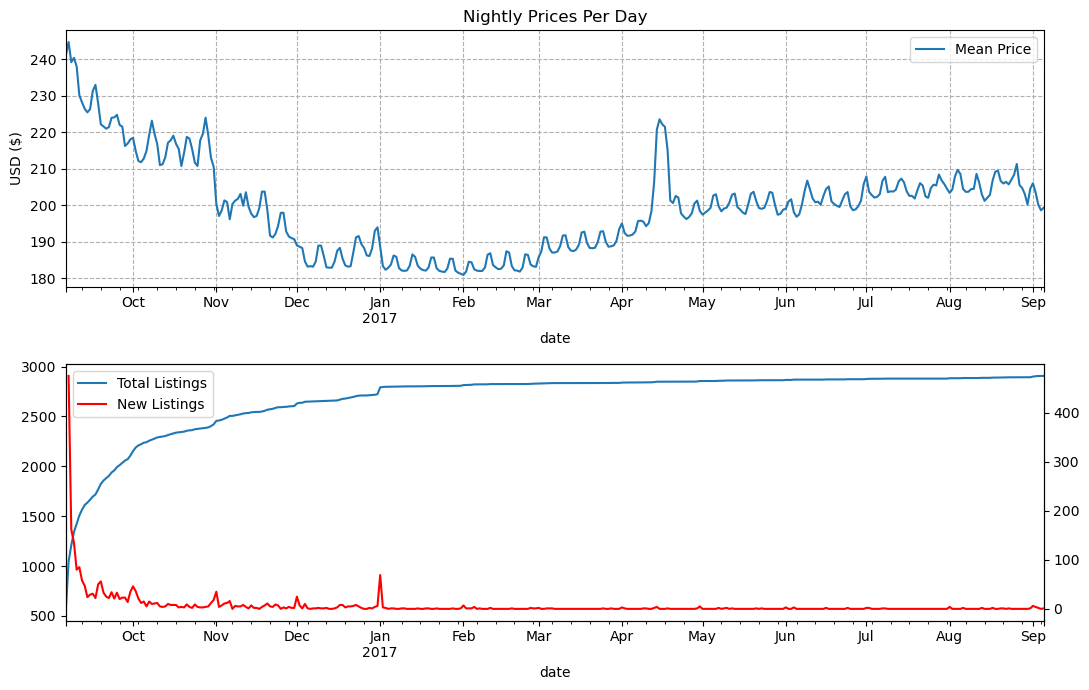

In [18]:
fig, ax = plt.subplots(nrows=2, figsize=(11, 7))

df_calendar.groupby("date")['price'].mean().rename("Mean Price").plot(ax=ax[0])
# df_calendar.groupby("date")['price'].median().rename("Median Price").plot(ax=ax[0])
ax[0].set_ylabel("USD ($)")
ax[0].set_title("Nightly Prices Per Day")
ax[0].legend()
ax[0].grid(ls="--")

df_calendar.groupby("date")['price'].count().plot(label='Total Listings', ax=ax[1])

ax2 = ax[1].twinx()
df_calendar.groupby("date")['price'].count().diff().plot(color='red', label="New Listings", ax=ax2)

lines, labels = ax[1].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

ax[1].legend(lines + lines2, labels + labels2)

fig.tight_layout()

In [19]:
#listing ids of listsings that exists on 1st of December and has a price on 1st of December
listings_on_december = df_calendar[df_calendar['date'] == '2016-12-01'].dropna()['listing_id'].unique()

len(listings_on_december)

2629

In [20]:
df_filtered = df_calendar[df_calendar['date'] >= "2016-12-01"]
df_filtered = df_filtered[df_filtered['listing_id'].isin(listings_on_december)].reset_index(drop=True)

df_filtered

,listing_id,date,available,price
0,5506,2016-12-01,t,145.0
1,5506,2016-12-02,t,145.0
2,5506,2016-12-03,t,145.0
3,5506,2016-12-04,t,145.0
4,5506,2016-12-05,t,145.0
...,...,...,...,...
733765,14933461,2017-09-01,t,165.0
733766,14933461,2017-09-02,t,165.0
733767,14933461,2017-09-03,t,165.0
733768,14933461,2017-09-04,t,165.0


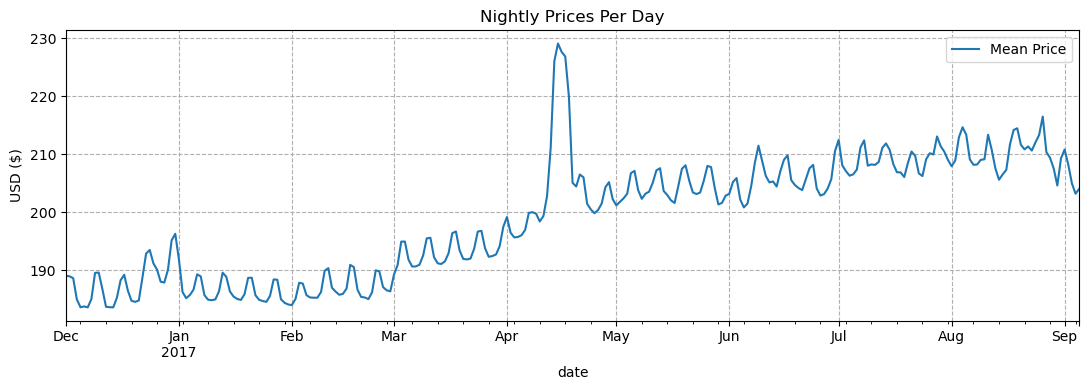

In [21]:
fig, ax = plt.subplots(figsize=(11, 4))

df_filtered.groupby("date")['price'].mean().rename("Mean Price").plot(ax=ax)
# df_filtered.groupby("date")['price'].median().rename("Median Price").plot(ax=ax[0])
ax.set_ylabel("USD ($)")
ax.set_title("Nightly Prices Per Day")
ax.legend()
ax.grid(ls="--")

fig.tight_layout()

In [22]:
df_listings_filtered = df_listings[df_listings['id'].isin(listings_on_december)].reset_index(drop=True)

df_listings_filtered.to_csv("data/preprocessed/listings.csv")

In [23]:
distanceMatrix = createDistanceMatrix(df_listings_filtered)

distanceMatrix.shape

(2629, 2629)

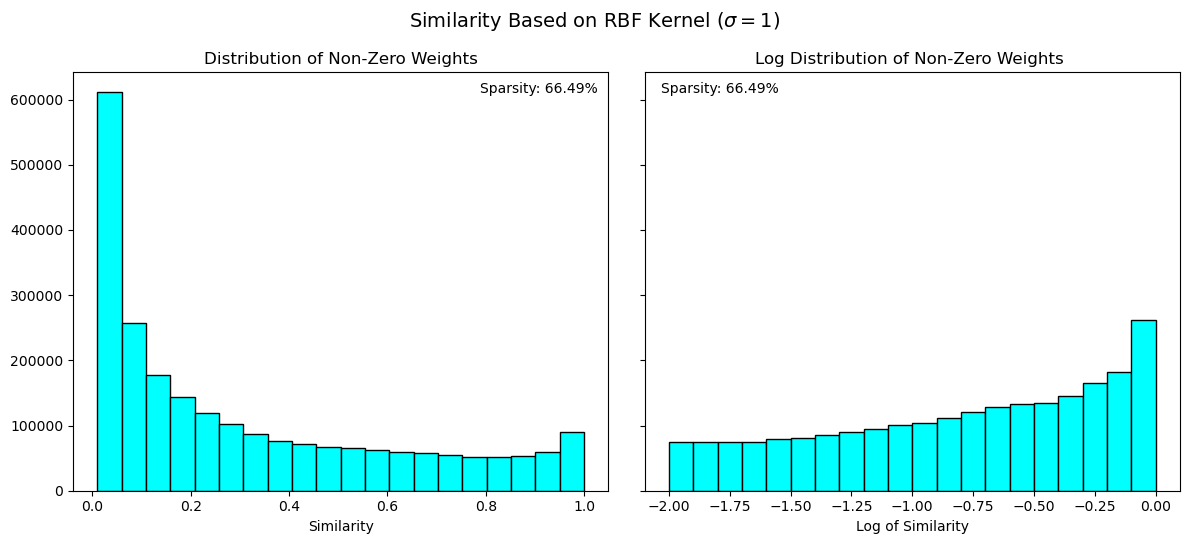

In [36]:
sigma = 1

sim_rbf = createSimilarityMatrix(distanceMatrix, sim_type='rbf', sigma=sigma)

sim_rbf_sparse = np.where(sim_rbf < 0.01, 0, sim_rbf) - np.eye(2629) #subtracting identity matrix removes self loops
sparsity = calculateSparsity(sim_rbf_sparse)

sim_rbf = sim_rbf_sparse[sim_rbf_sparse != 0]

sim_rbf = np.clip(sim_rbf, 1e-2, 1e2)

fig, ax = plt.subplots(ncols=2, figsize=(12, 5.5), sharey=True)

ax[0].hist(sim_rbf.flatten(), bins=20, edgecolor='black', color='cyan')
ax[0].set_xlabel("Similarity")
ax[0].set_title("Distribution of Non-Zero Weights")

ax[1].hist(np.log10(sim_rbf.flatten()), bins=20, edgecolor='black', color='cyan')
ax[1].set_xlabel("Log of Similarity")
ax[1].set_title("Log Distribution of Non-Zero Weights ")

ax[0].annotate(f"Sparsity: {sparsity:.2f}%", xy=(0.76, 0.95), xycoords='axes fraction')
ax[1].annotate(f"Sparsity: {sparsity:.2f}%", xy=(0.03, 0.95), xycoords='axes fraction')

fig.suptitle(f"Similarity Based on RBF Kernel ($\sigma={sigma}$)", fontsize=14)

fig.tight_layout()

fig.savefig("figures/similarity_histogram_sigma1.pdf")

In [46]:
graph = nx.Graph(sim_rbf_sparse - np.eye(2629))

nx.is_connected(graph)

True

In [47]:
sigma = 1

sim_rbf = createSimilarityMatrix(distanceMatrix, sim_type='rbf', sigma=sigma)

sim_rbf_sparse = np.where(sim_rbf < 0.01, 0, sim_rbf)

sim_rbf_sparse -= np.eye(2629) #subtracting identity matrix removes self edges

np.save("data/adjacency/sigma1.npy", sim_rbf_sparse)

In [49]:
np.load("data/adjacency/sigma1.npy")

array([[0.        , 0.78351445, 0.4647304 , ..., 0.        , 0.        ,
        0.        ],
       [0.78351445, 0.        , 0.21667785, ..., 0.        , 0.        ,
        0.        ],
       [0.4647304 , 0.21667785, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.2389296 ,
        0.14943169],
       [0.        , 0.        , 0.        , ..., 0.2389296 , 0.        ,
        0.95692091],
       [0.        , 0.        , 0.        , ..., 0.14943169, 0.95692091,
        0.        ]])